In [1]:
import gym
import gym_sokoban
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils.convert import to_networkx

from data.embedding import MinimalEmbedding, NoWallsEmbedding

In [2]:
%load_ext autoreload
%autoreload 2

## Setting up a static world, showing the graph

In [51]:
SEED = 42
WORLD = "Sokoban-small-v0"

In [52]:
env = gym.make(WORLD)
random.seed(SEED)
np.random.seed(SEED)
emb = NoWallsEmbedding()
_ = env.reset()

In [5]:
def get_state(emb):
    pixels_state = env.render("tiny_rgb_array")
    
    G = emb(pixels_state)
    pos_map = {i: pos.numpy() for i, pos in enumerate(G.pos)}

    # Swap x, y, invert y
    pos_map = {i: np.array([x, y]) for i, (y, x) in pos_map.items()}
    max_y = max([y for x, y in pos_map.values()])
    pos_map = {i: np.array([x, max_y - y]) for i, (x, y) in pos_map.items()}

    # Nodes indexes
    labels = {i: str(i) for i in range(len(G.x))}
    return G, pos_map, labels

In [6]:
G, pos_map, labels = get_state(emb)

In [7]:
def show_grids():
    fix, axes = plt.subplots(1, 2)
    axes[0].imshow(env.render("rgb_array"))
    axes[1].imshow(env.render("tiny_rgb_array"))
    plt.show()
    
def show_graph(graph_nx, pos_map, node_text=None, node_color=None, title=""):
    plt.figure(1, figsize=(7,7)) 
    plt.title(title)
    nx.draw(graph_nx, 
            cmap=plt.get_cmap('seismic'), 
            node_color=node_color, 
            labels=node_text, 
            node_size=100, 
            linewidths=6, 
            font_color="w",
            pos=pos_map)
    plt.show()

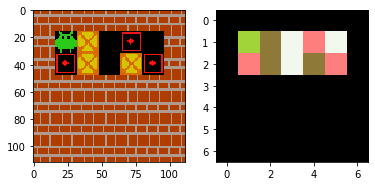

In [8]:
show_grids()

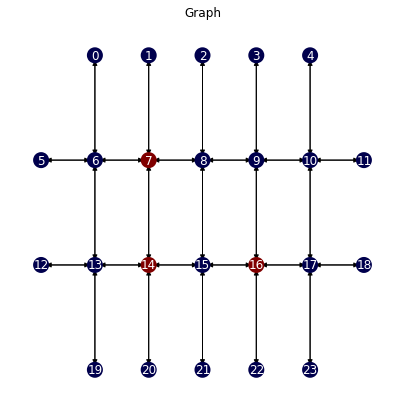

In [9]:
show_graph(to_networkx(G), pos_map, node_color=G.x[:, 0], node_text=labels, title="Graph")

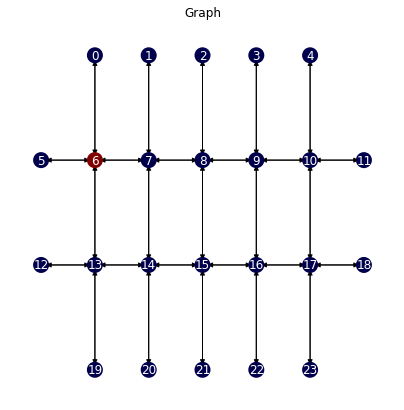

In [10]:
show_graph(to_networkx(G), pos_map, node_color=G.x[:, 1], node_text=labels, title="Graph")

## Testing exploration

In [11]:
from rl.explore import epsilon_greedy
random_generator = random.Random()

In [12]:
%timeit epsilon_greedy(state=G, net=None, eps=1.0, random_generator=random_generator)

137 µs ± 39 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
lookup = env.get_action_lookup()
env.get_action_lookup()

{0: 'no operation',
 1: 'push up',
 2: 'push down',
 3: 'push left',
 4: 'push right',
 5: 'move up',
 6: 'move down',
 7: 'move left',
 8: 'move right'}

Important note: **"push" always works** (it moves the player if there is a box or not, but **"move"** does not work with boxes.

In [14]:
def test_node_to_action():
    # Get current state, show nodes indexes and color player
    G, pos_map, labels = get_state(emb)
    show_graph(to_networkx(G), pos_map, node_color=G.x[:, 1], node_text=labels, title="Graph before action")
    show_grids()
    node_idx, action = epsilon_greedy(state=G, 
                                      net=None, 
                                      eps=1.0, 
                                      random_generator=random_generator, 
                                      walls_prob=0.0, 
                                      static_prob=0.0)
    print(f"Node index: {node_idx.item()}. Action: {action} ({lookup[action]}).")

    # Take action
    env.step(action)

    # Get new state, show nodes indexes and color player
    G, pos_map, labels = get_state(emb)
    show_graph(to_networkx(G), pos_map, node_color=G.x[:, 1], node_text=labels, title="Graph after action")
    show_grids()

STEP 0


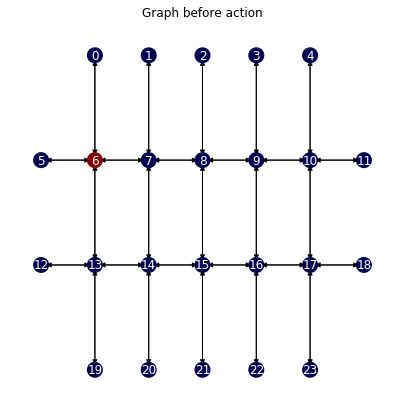

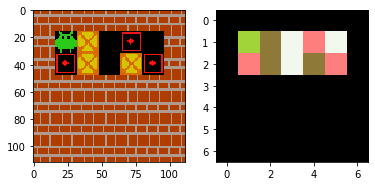

Node index: 13. Action: 6 (move down).


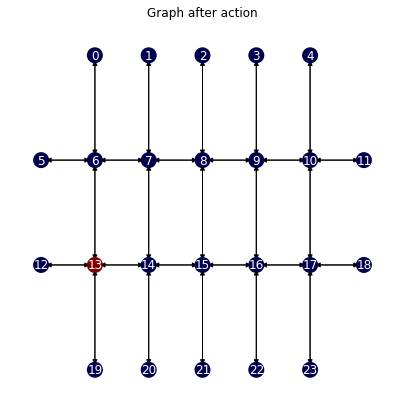

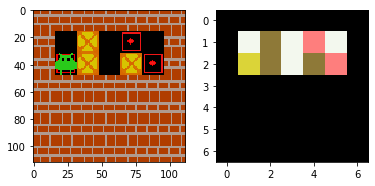

STEP 1


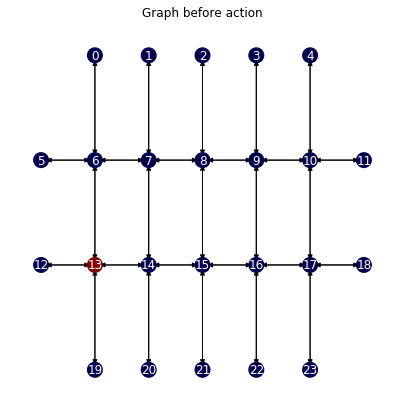

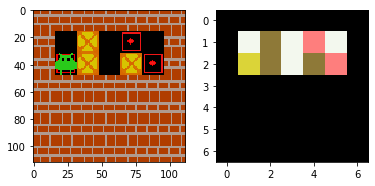

Node index: 6. Action: 5 (move up).


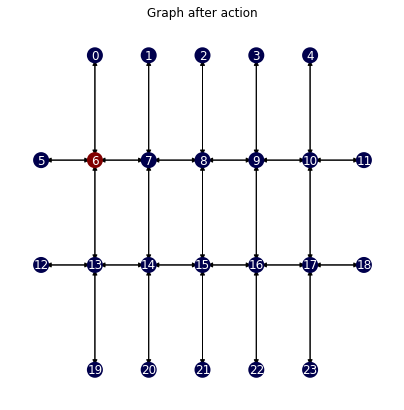

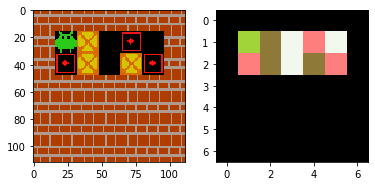

STEP 2


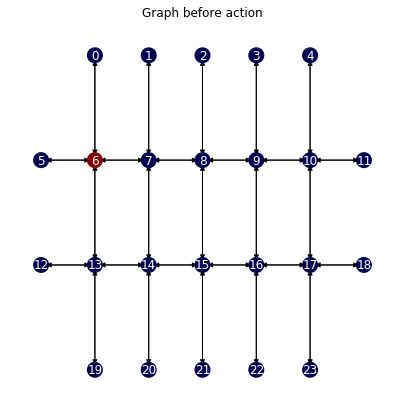

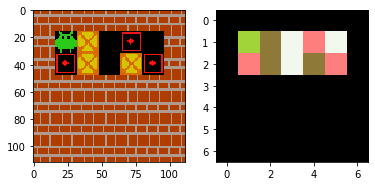

Node index: 7. Action: 4 (push right).


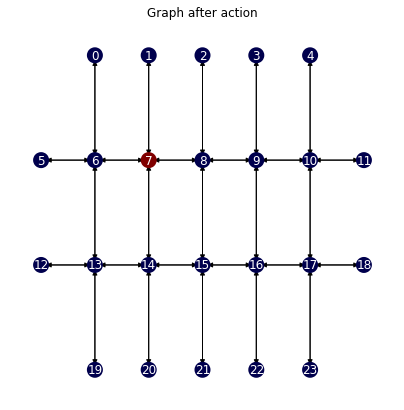

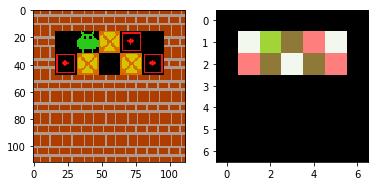

STEP 3


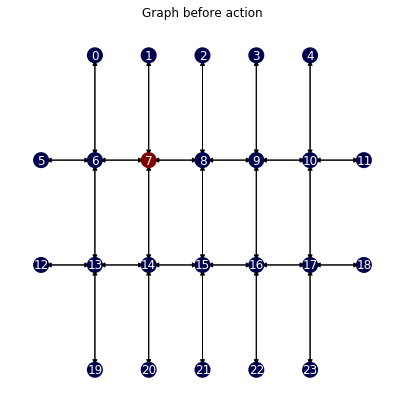

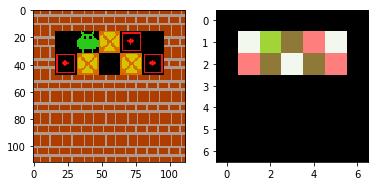

Node index: 8. Action: 4 (push right).


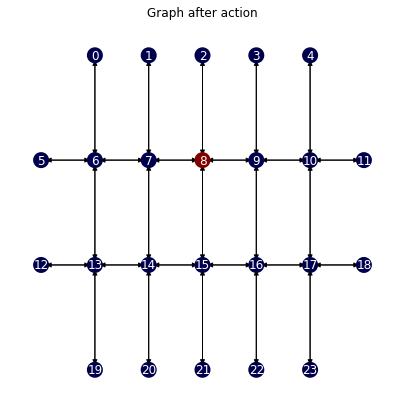

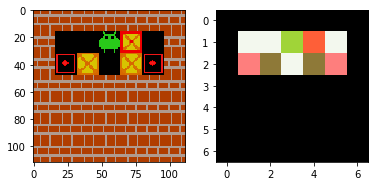

STEP 4


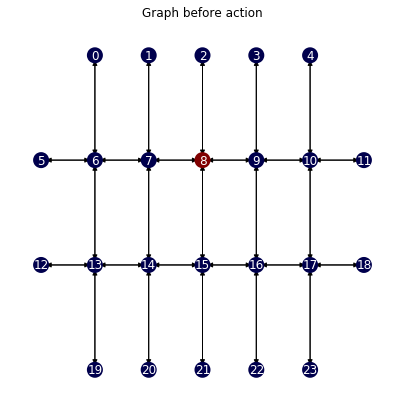

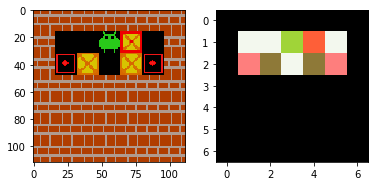

Node index: 9. Action: 4 (push right).


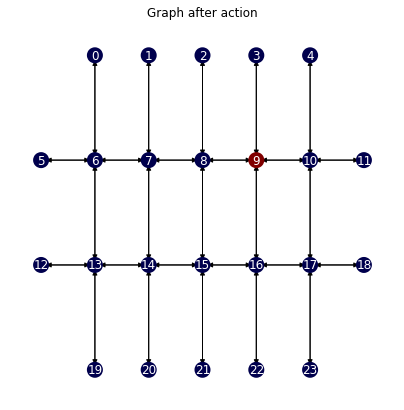

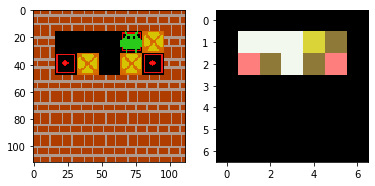

STEP 5


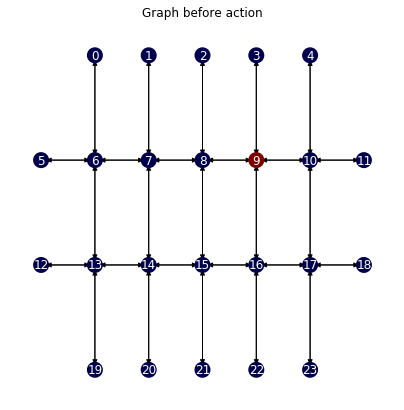

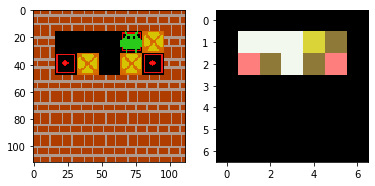

Node index: 8. Action: 7 (move left).


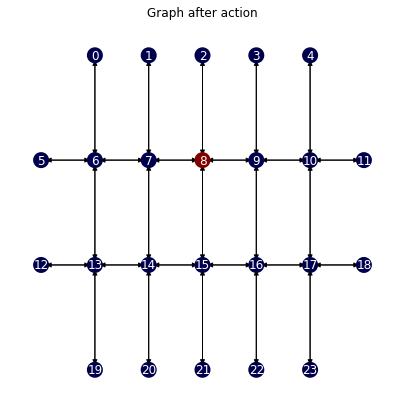

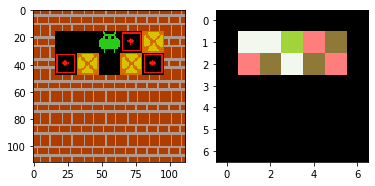

STEP 6


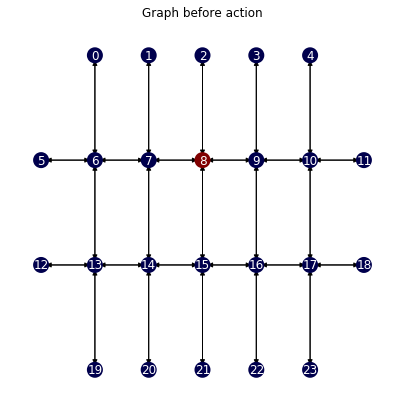

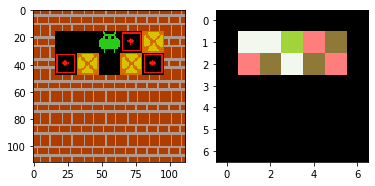

Node index: 7. Action: 7 (move left).


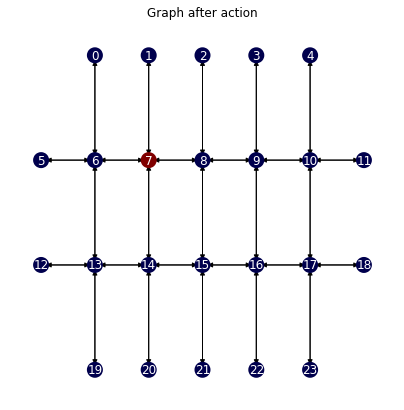

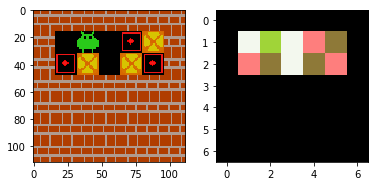

STEP 7


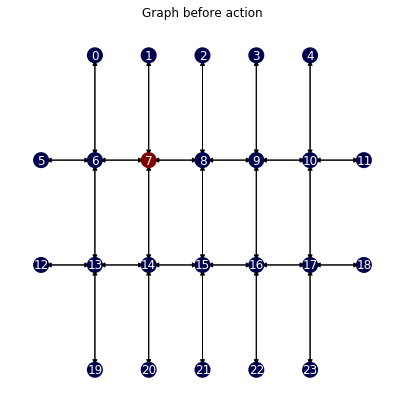

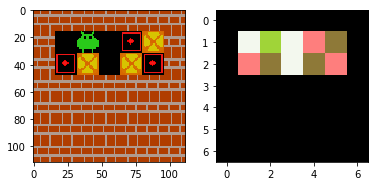

Node index: 6. Action: 7 (move left).


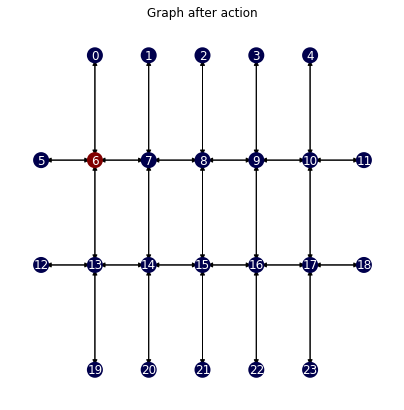

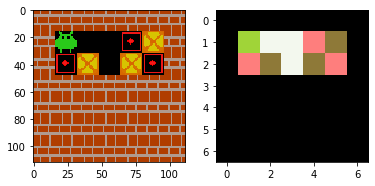

STEP 8


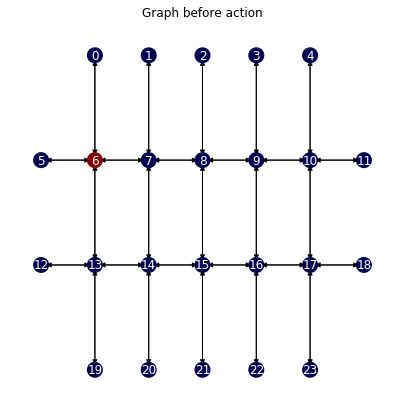

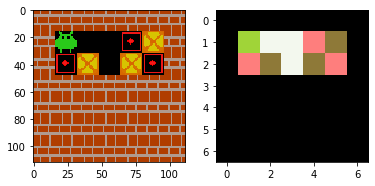

Node index: 13. Action: 6 (move down).


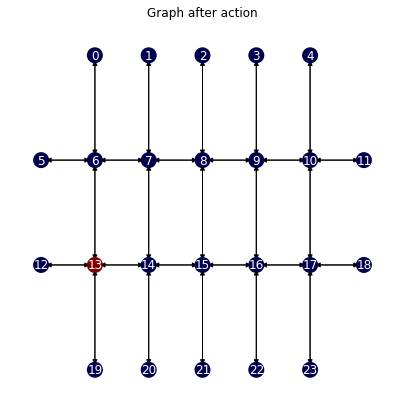

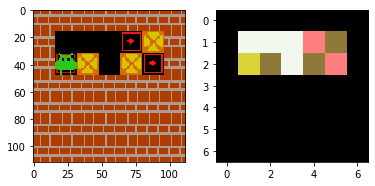

STEP 9


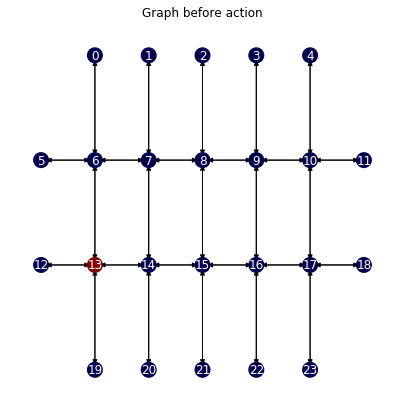

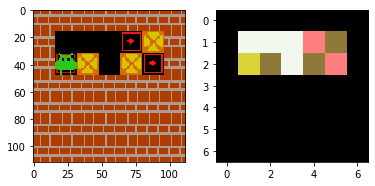

Node index: 6. Action: 5 (move up).


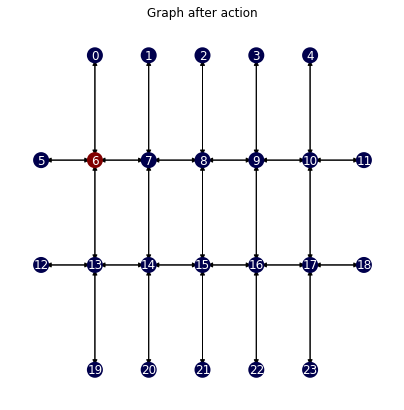

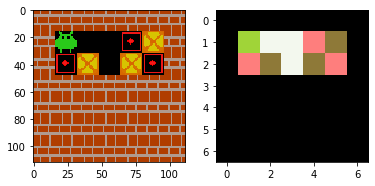

STEP 10


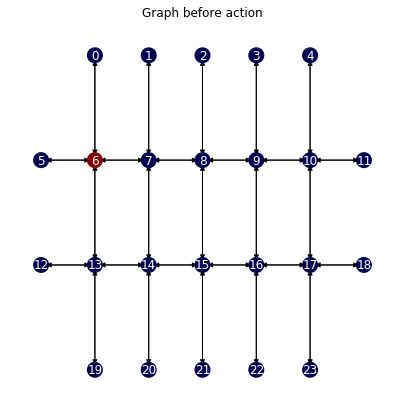

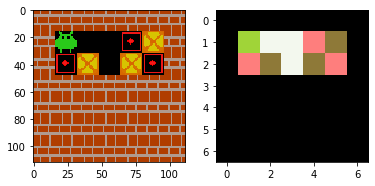

Node index: 13. Action: 6 (move down).


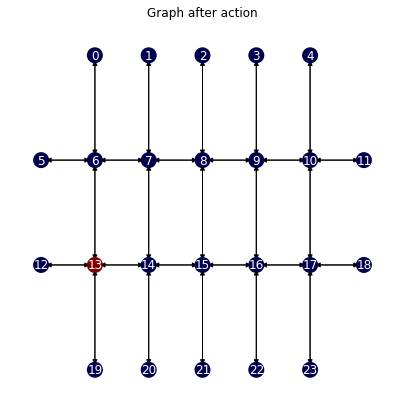

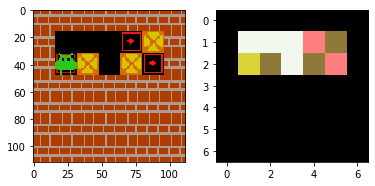

STEP 11


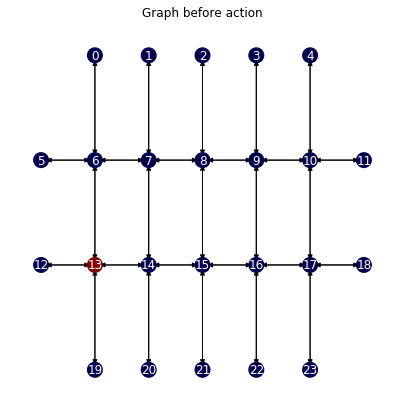

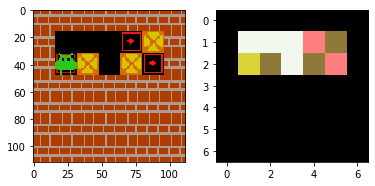

Node index: 6. Action: 5 (move up).


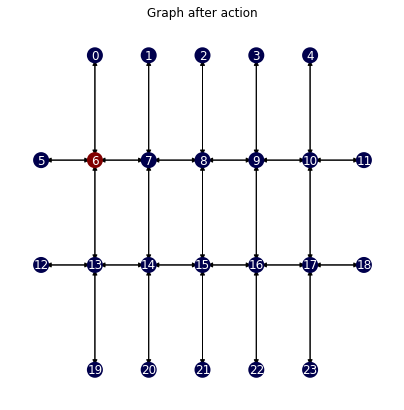

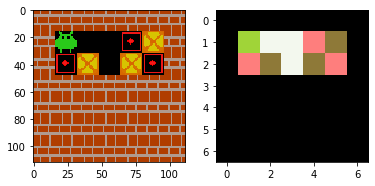

STEP 12


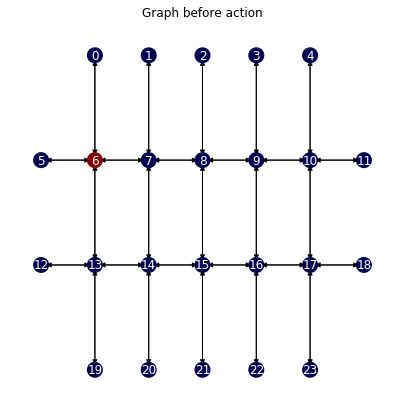

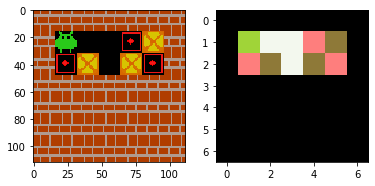

Node index: 13. Action: 6 (move down).


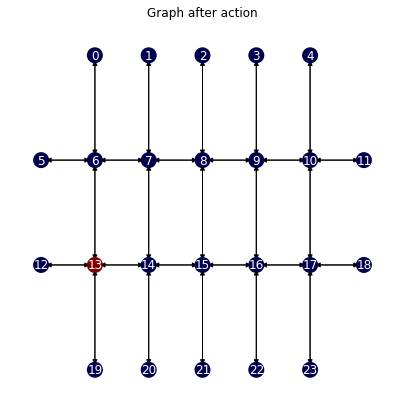

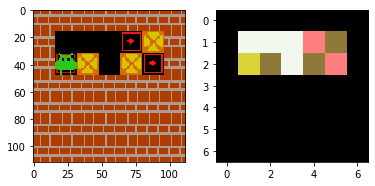

STEP 13


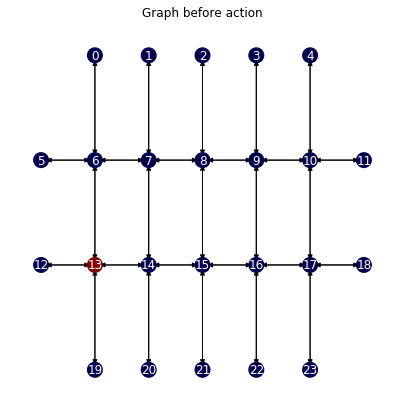

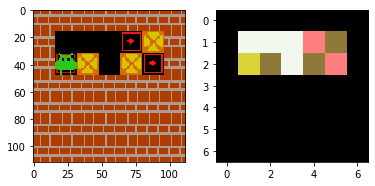

Node index: 14. Action: 4 (push right).


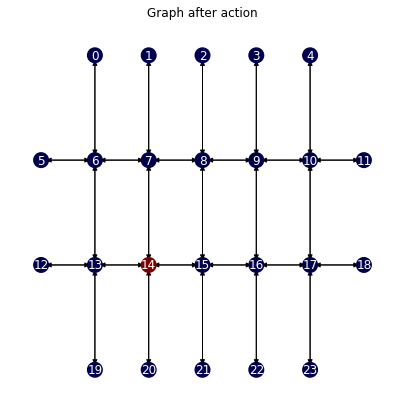

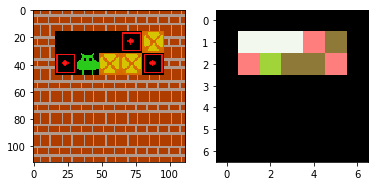

STEP 14


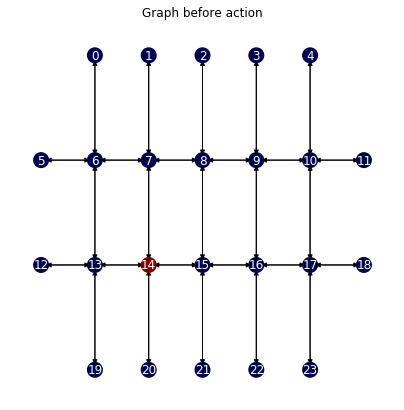

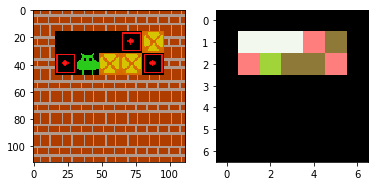

Node index: 13. Action: 7 (move left).


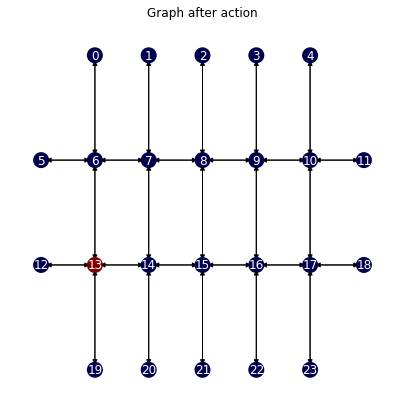

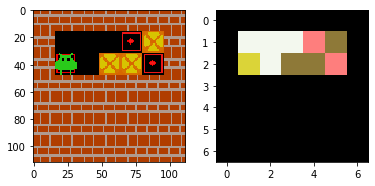

STEP 15


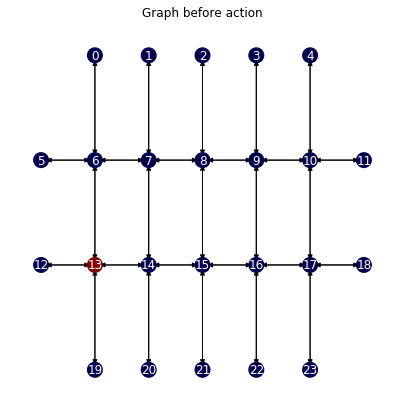

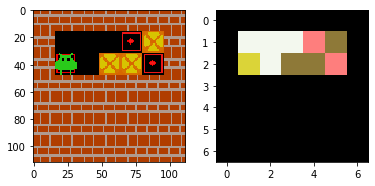

Node index: 6. Action: 5 (move up).


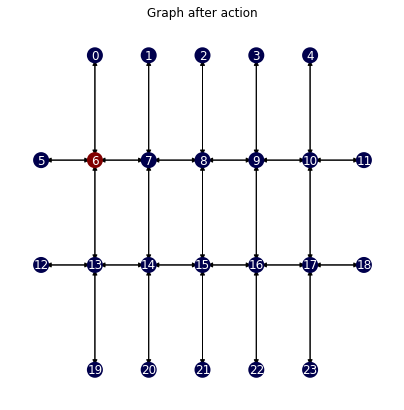

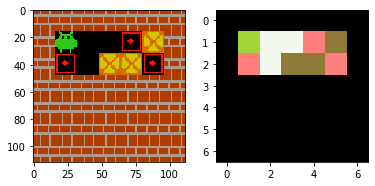

STEP 16


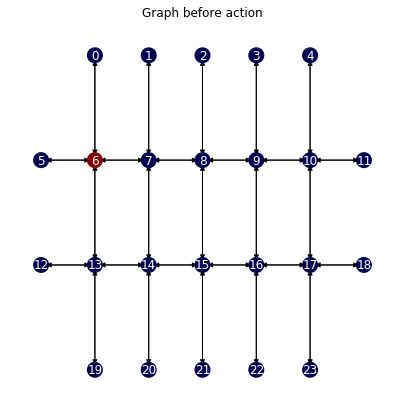

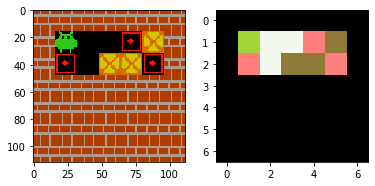

Node index: 7. Action: 8 (move right).


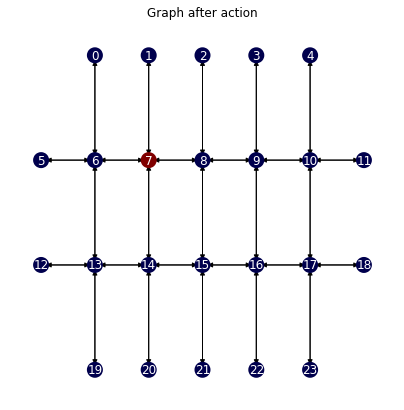

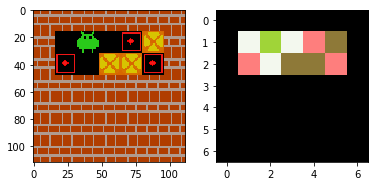

STEP 17


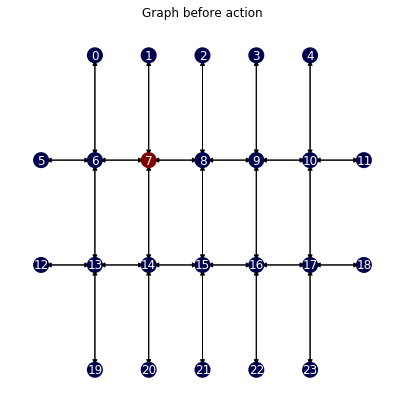

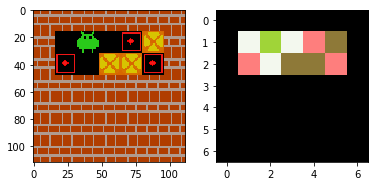

Node index: 8. Action: 8 (move right).


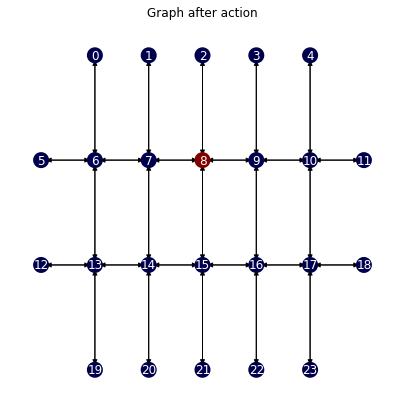

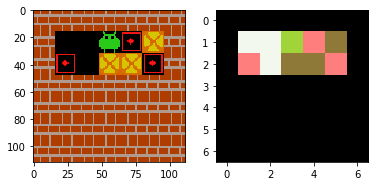

STEP 18


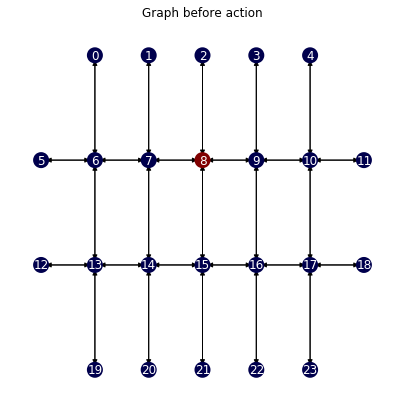

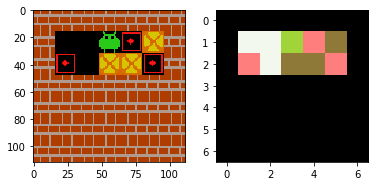

Node index: 7. Action: 7 (move left).


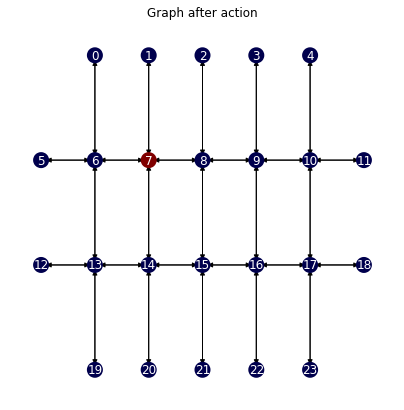

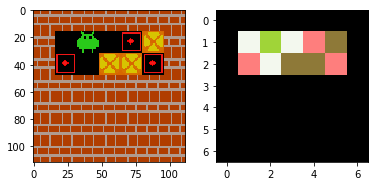

STEP 19


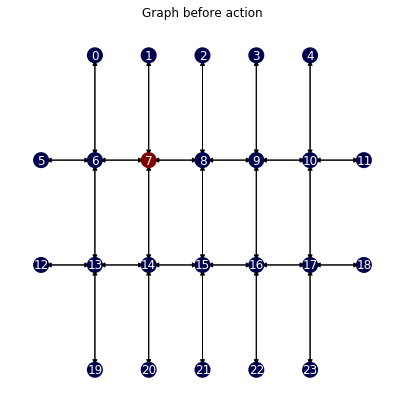

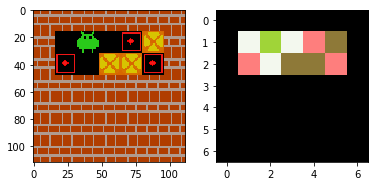

Node index: 8. Action: 8 (move right).


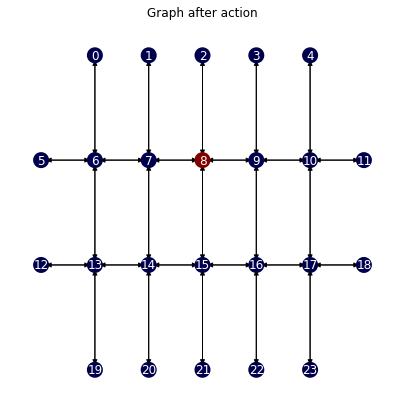

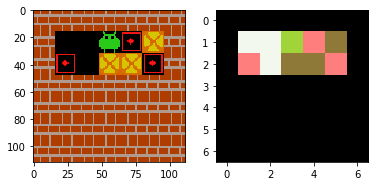

STEP 20


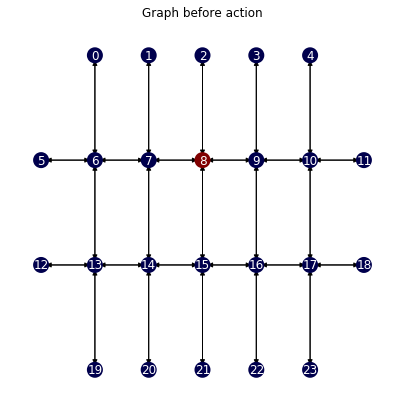

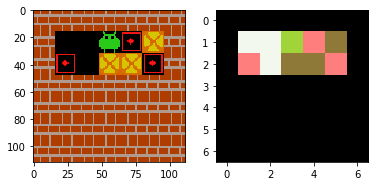

Node index: 15. Action: 2 (push down).


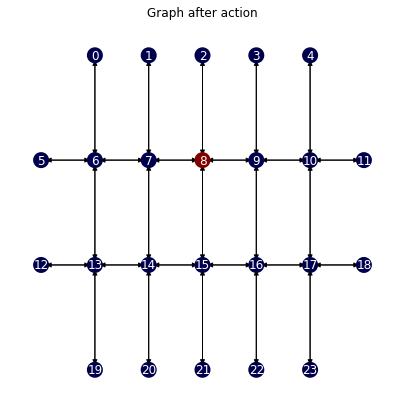

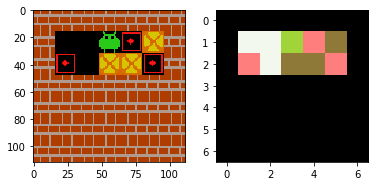

STEP 21


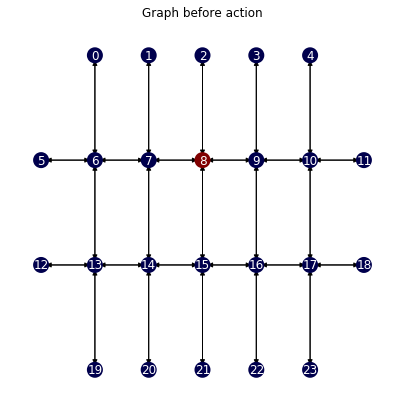

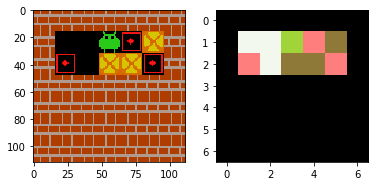

Node index: 15. Action: 2 (push down).


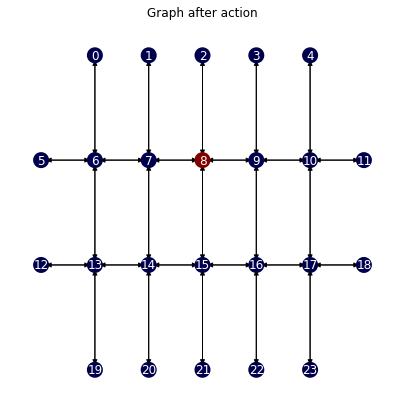

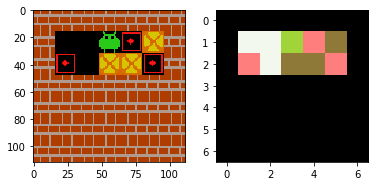

STEP 22


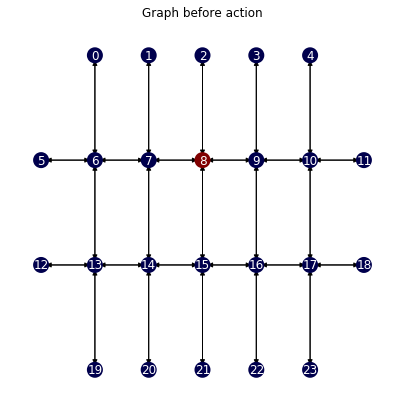

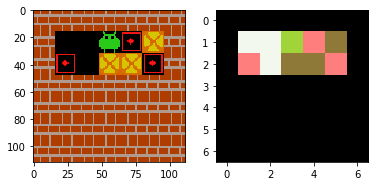

Node index: 9. Action: 8 (move right).


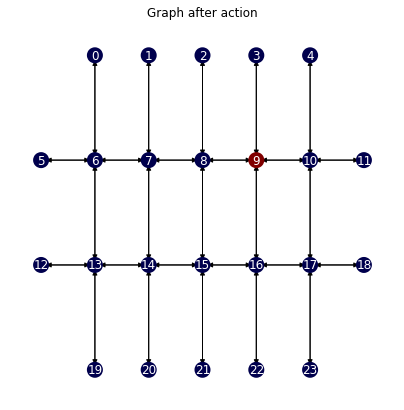

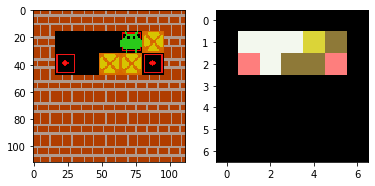

STEP 23


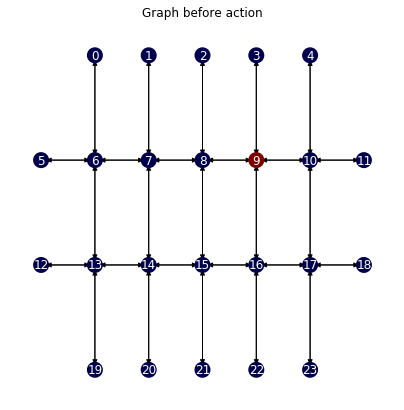

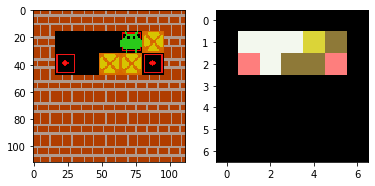

Node index: 16. Action: 2 (push down).


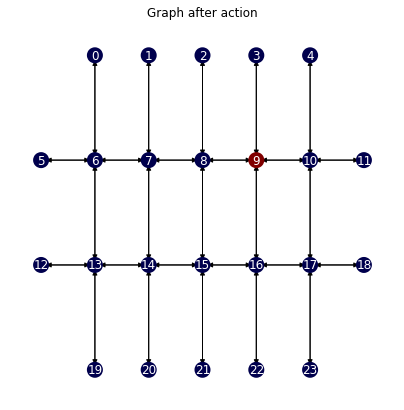

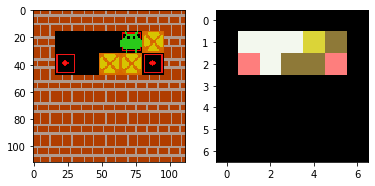

STEP 24


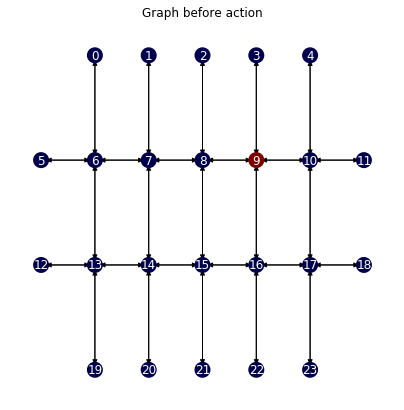

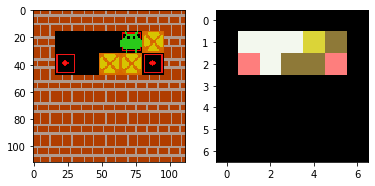

Node index: 10. Action: 4 (push right).


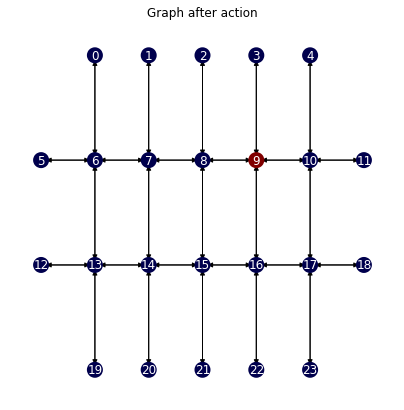

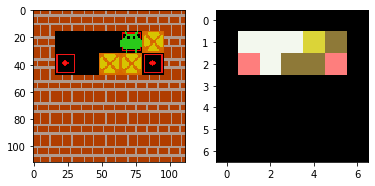

STEP 25


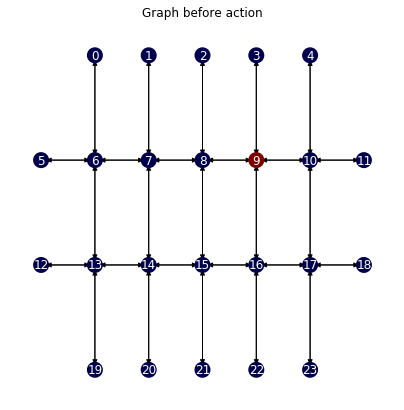

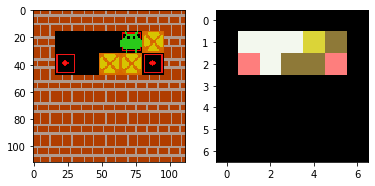

Node index: 8. Action: 7 (move left).


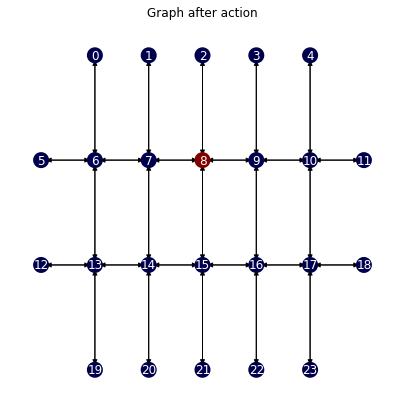

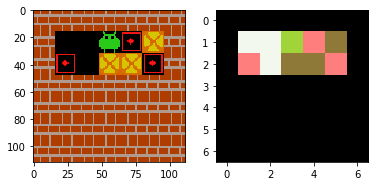

STEP 26


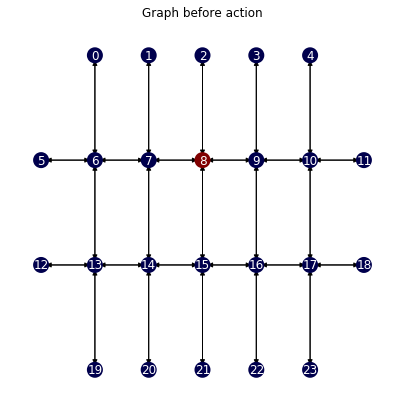

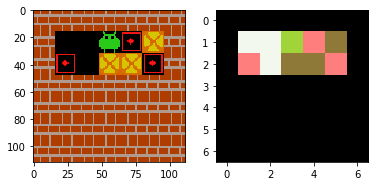

Node index: 9. Action: 8 (move right).


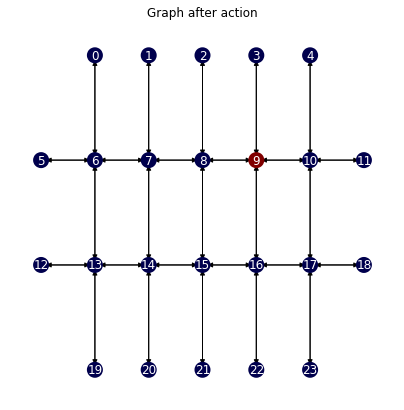

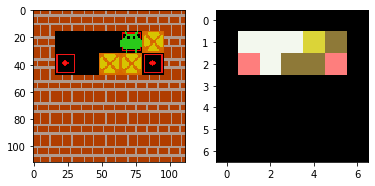

STEP 27


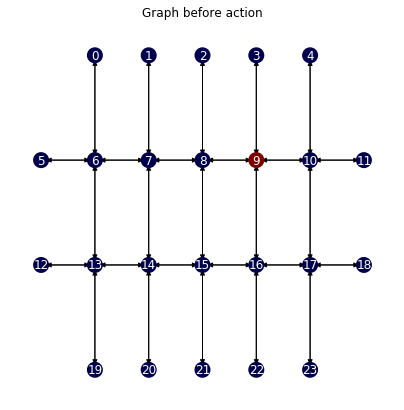

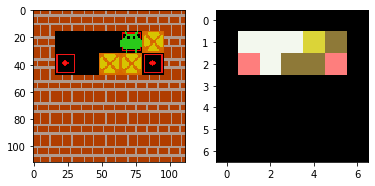

Node index: 16. Action: 2 (push down).


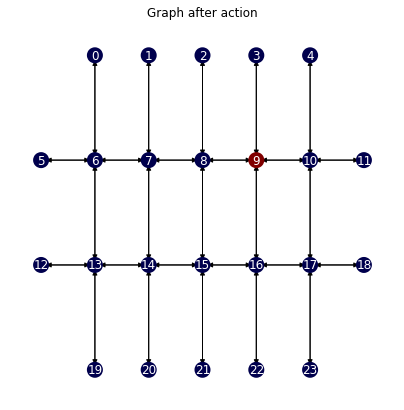

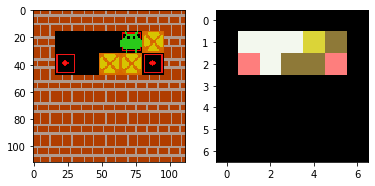

STEP 28


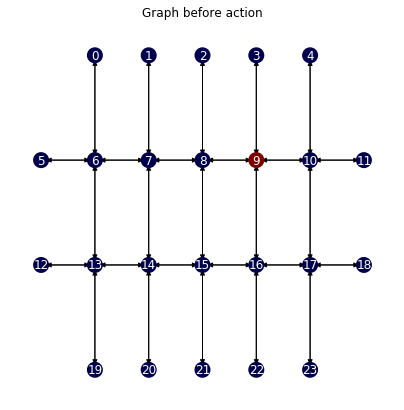

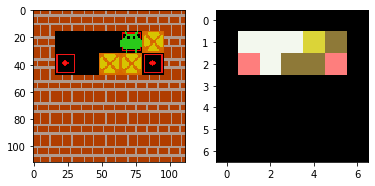

Node index: 8. Action: 7 (move left).


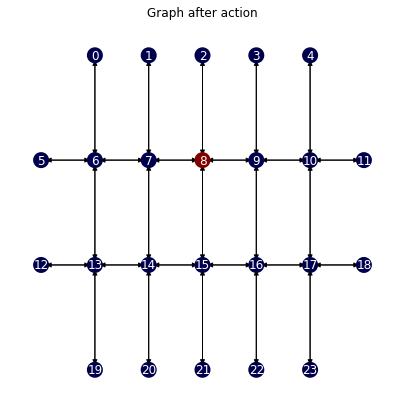

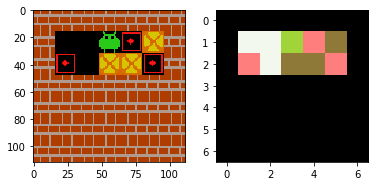

STEP 29


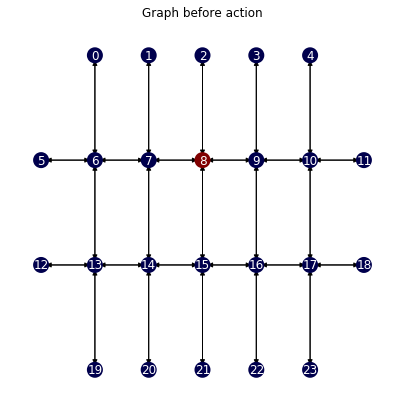

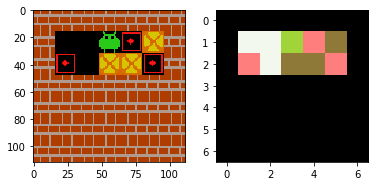

Node index: 9. Action: 8 (move right).


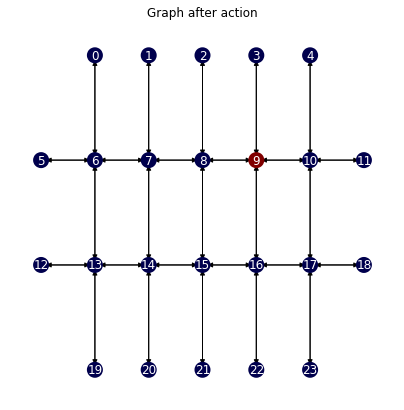

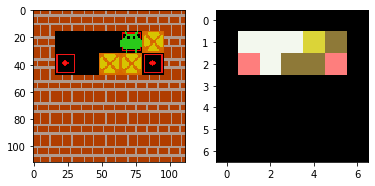

STEP 30


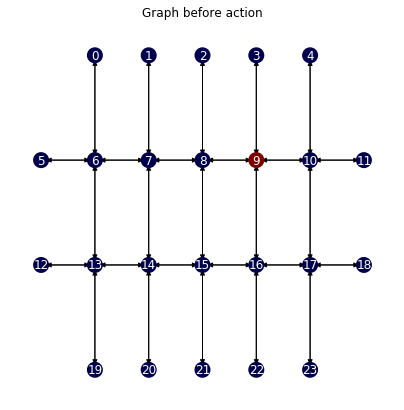

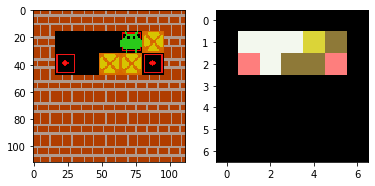

Node index: 16. Action: 2 (push down).


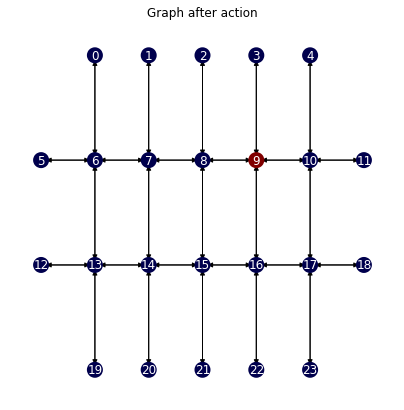

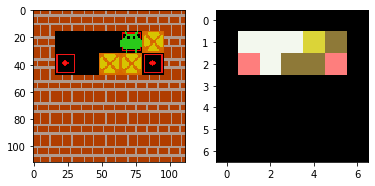

STEP 31


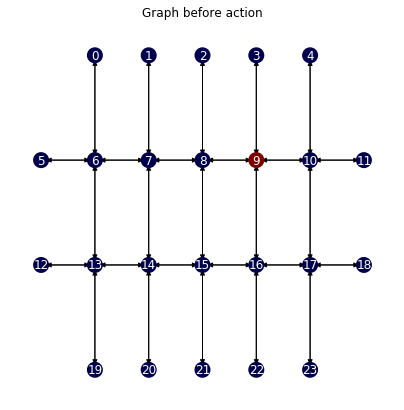

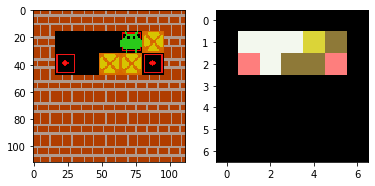

Node index: 16. Action: 2 (push down).


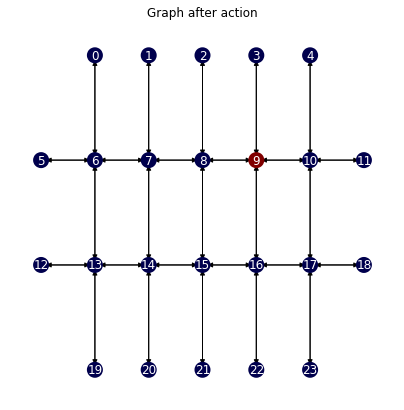

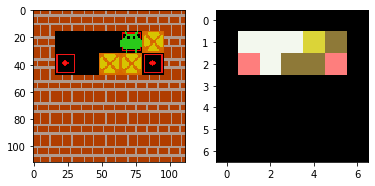

STEP 32


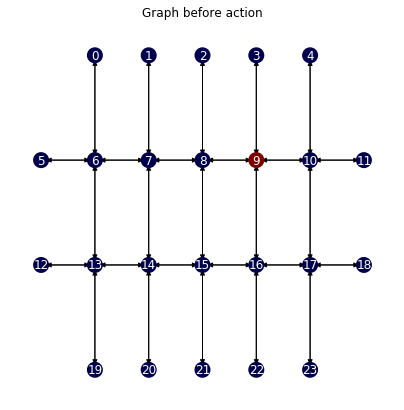

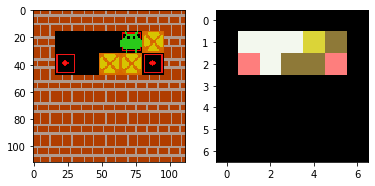

Node index: 16. Action: 2 (push down).


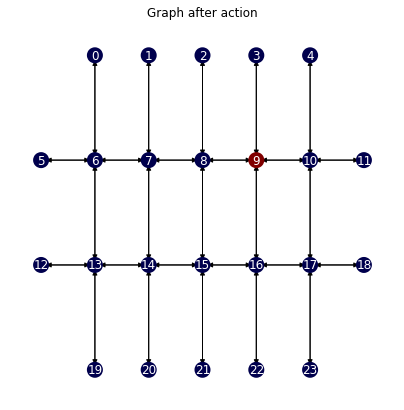

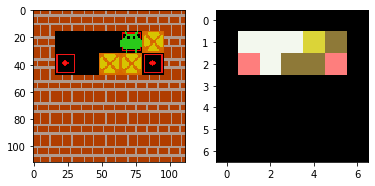

STEP 33


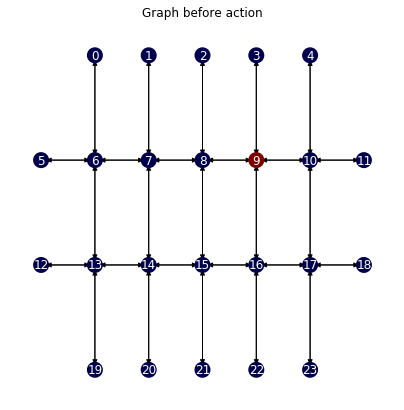

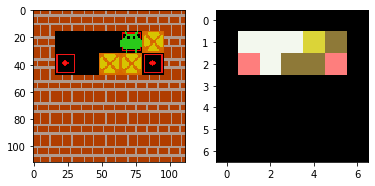

Node index: 10. Action: 4 (push right).


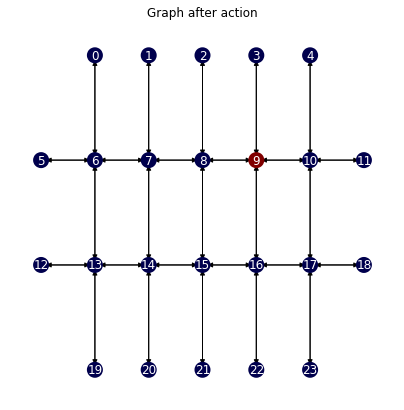

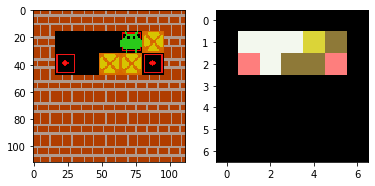

STEP 34


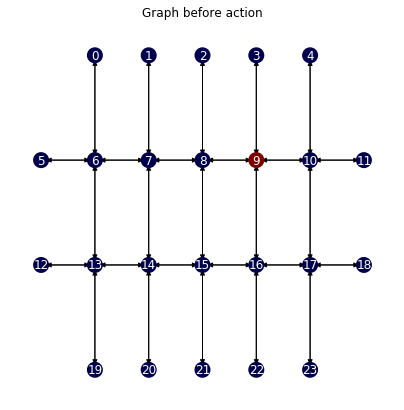

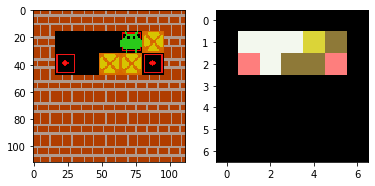

Node index: 8. Action: 7 (move left).


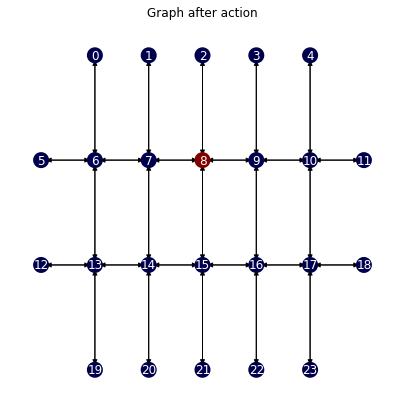

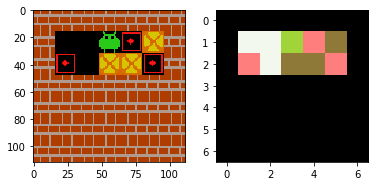

STEP 35


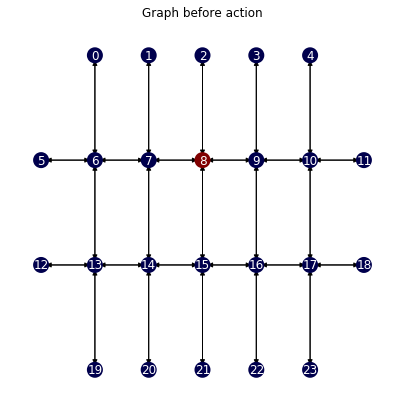

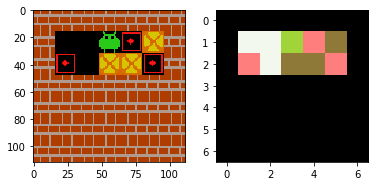

Node index: 9. Action: 8 (move right).


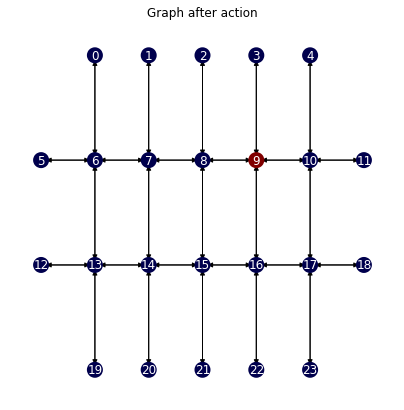

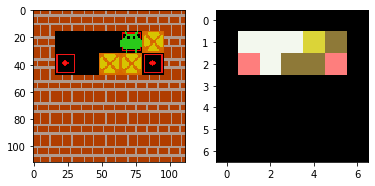

STEP 36


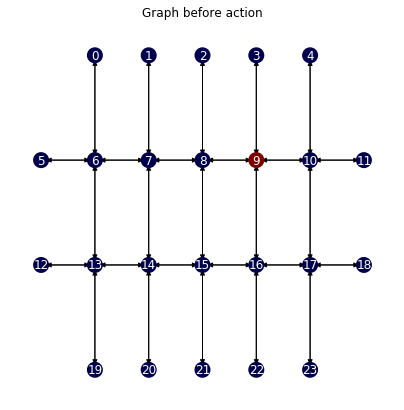

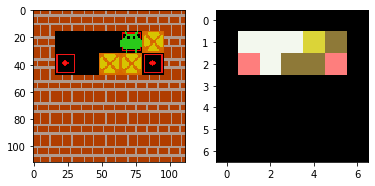

Node index: 16. Action: 2 (push down).


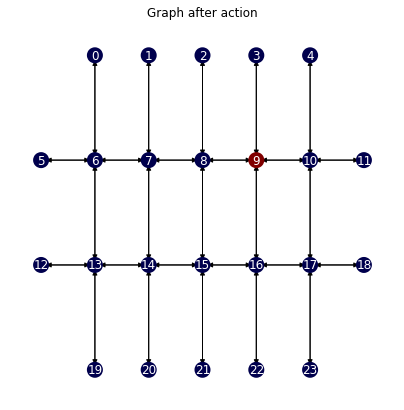

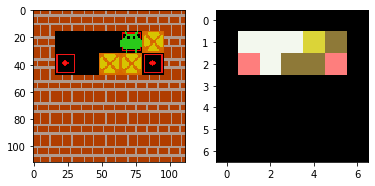

STEP 37


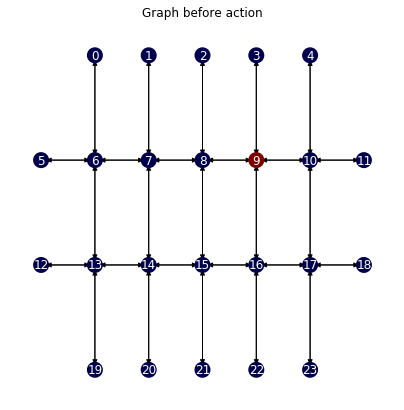

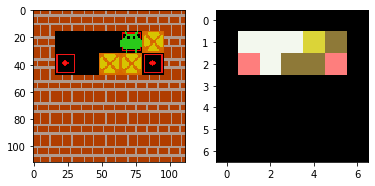

Node index: 10. Action: 4 (push right).


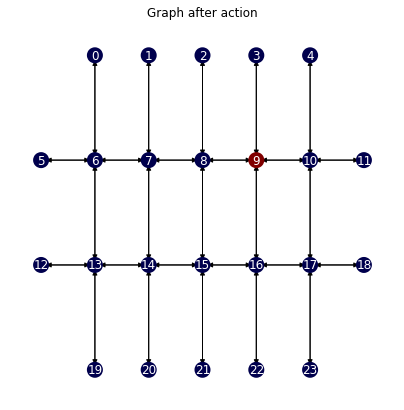

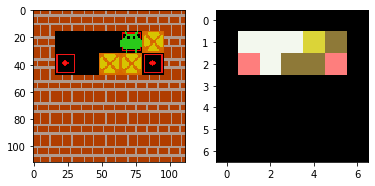

STEP 38


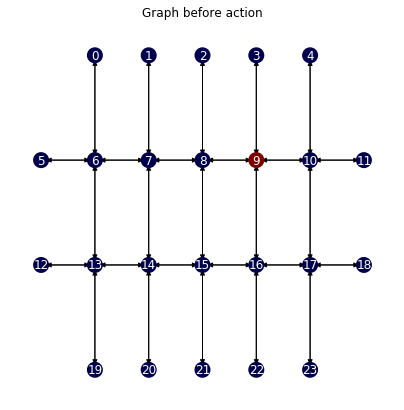

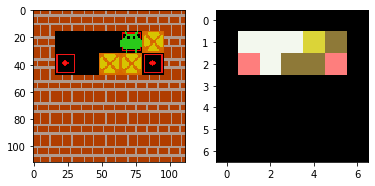

Node index: 8. Action: 7 (move left).


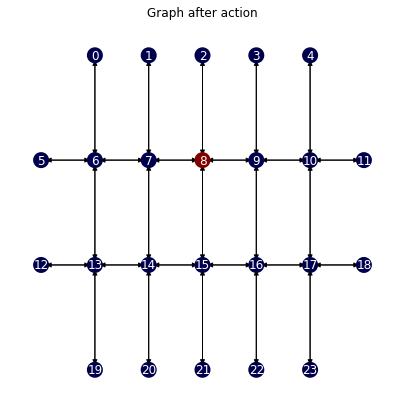

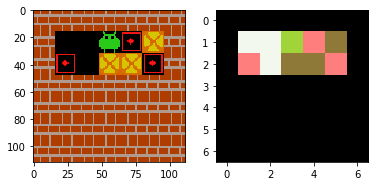

STEP 39


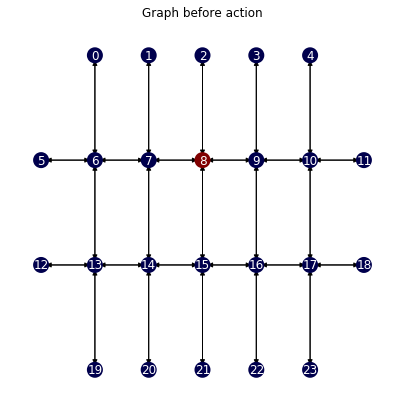

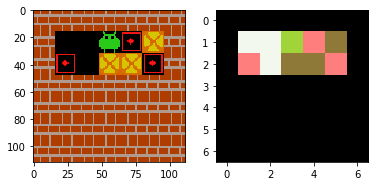

Node index: 9. Action: 8 (move right).


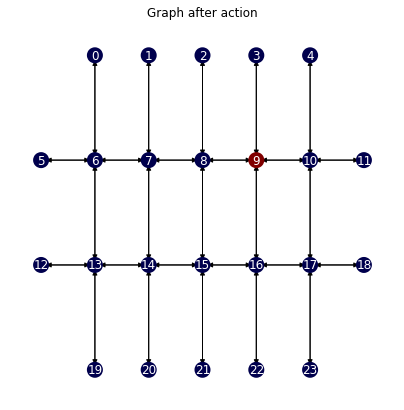

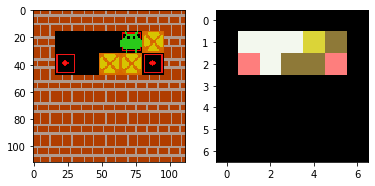

STEP 40


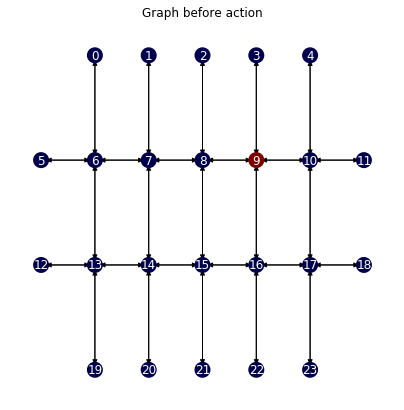

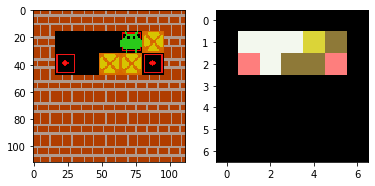

Node index: 8. Action: 7 (move left).


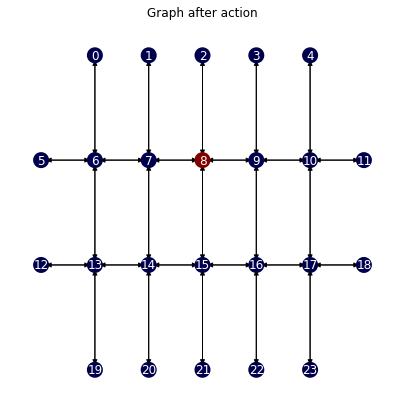

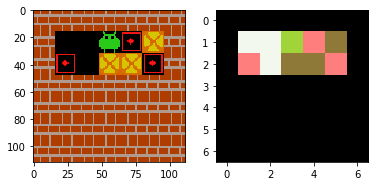

STEP 41


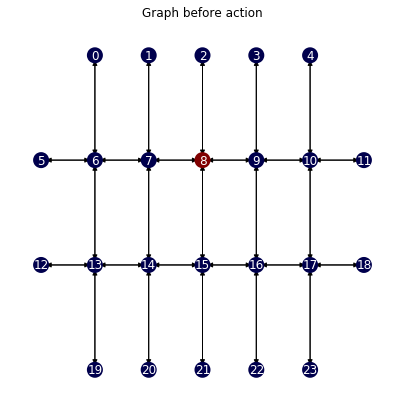

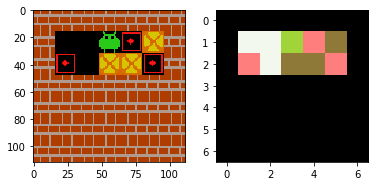

Node index: 7. Action: 7 (move left).


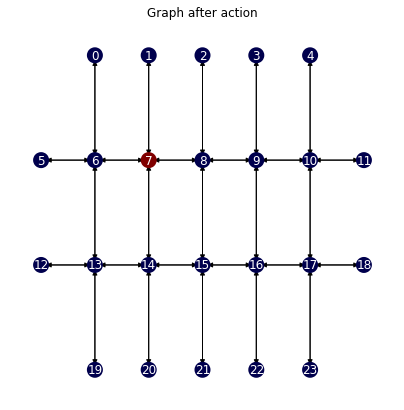

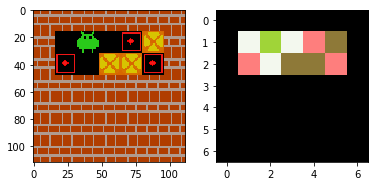

STEP 42


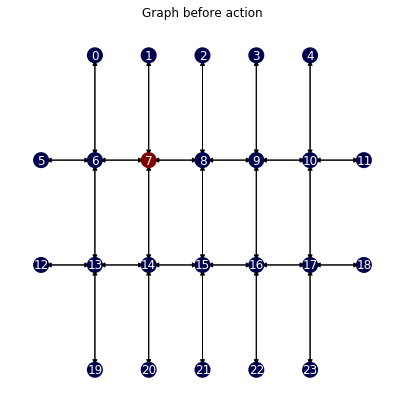

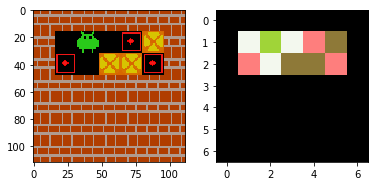

Node index: 14. Action: 6 (move down).


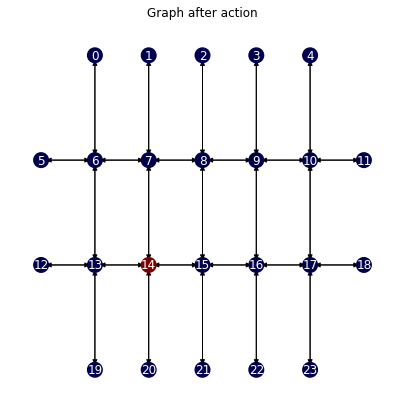

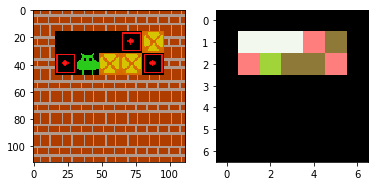

STEP 43


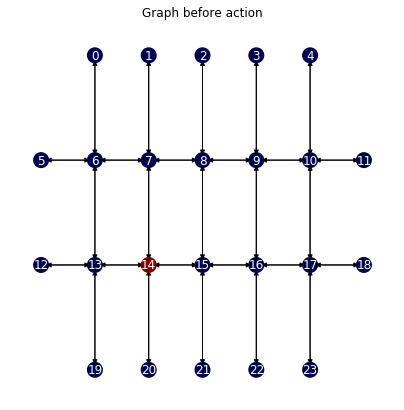

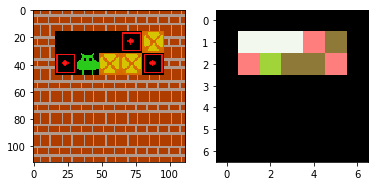

Node index: 13. Action: 7 (move left).


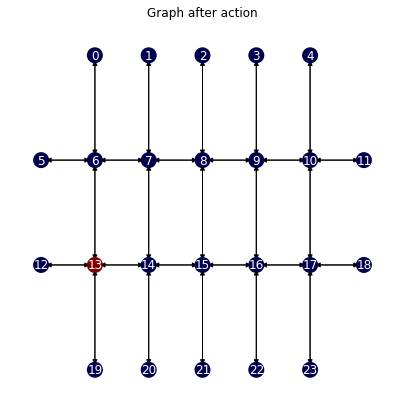

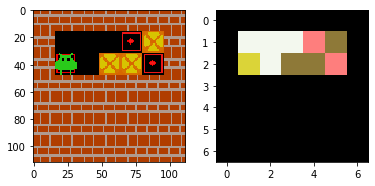

STEP 44


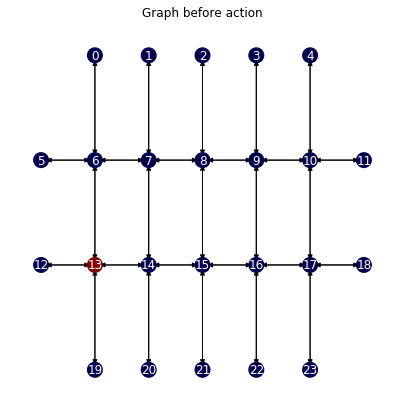

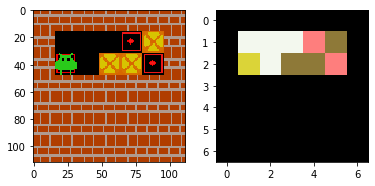

Node index: 14. Action: 8 (move right).


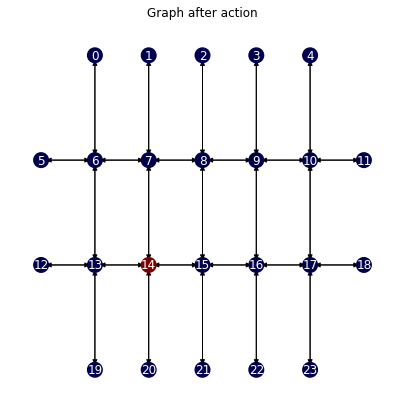

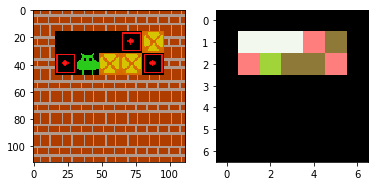

STEP 45


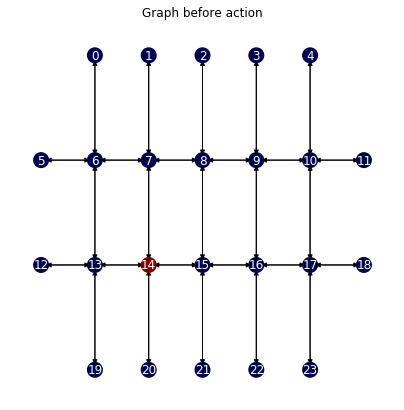

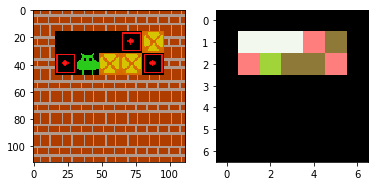

Node index: 15. Action: 4 (push right).


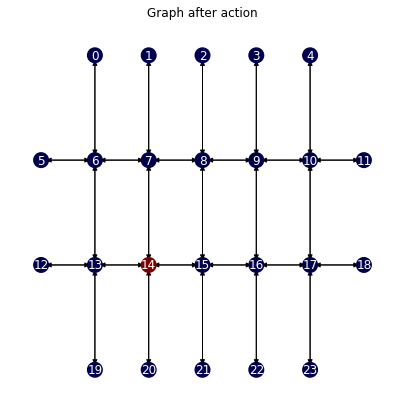

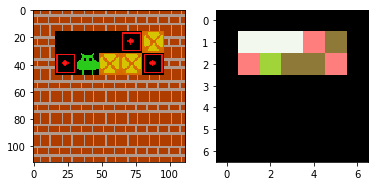

STEP 46


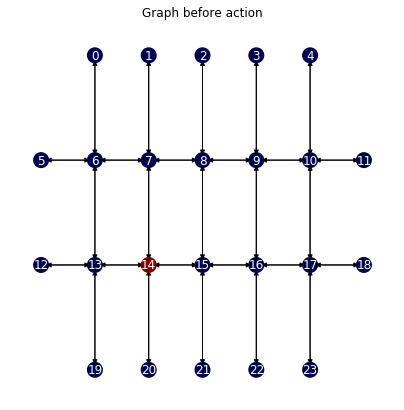

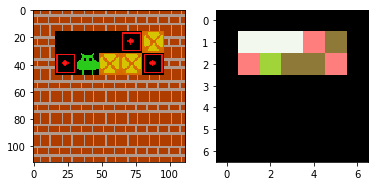

Node index: 7. Action: 5 (move up).


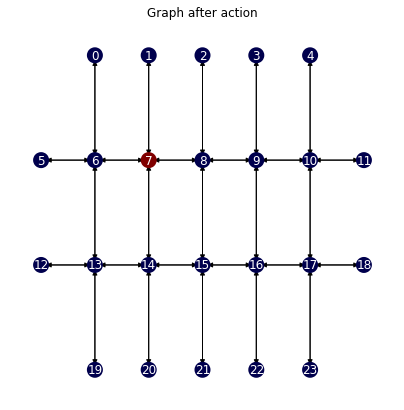

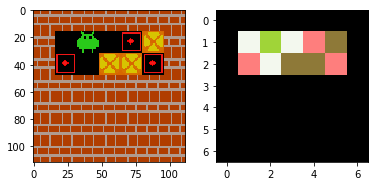

STEP 47


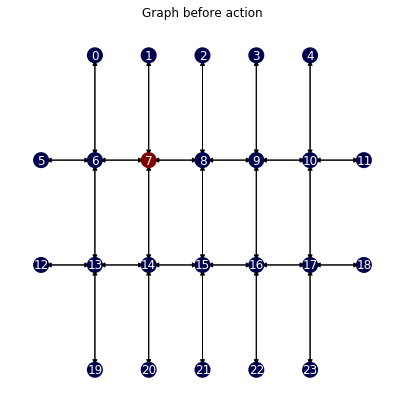

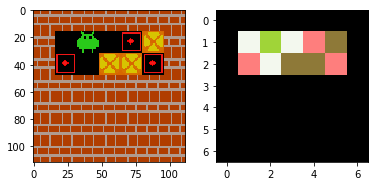

Node index: 8. Action: 8 (move right).


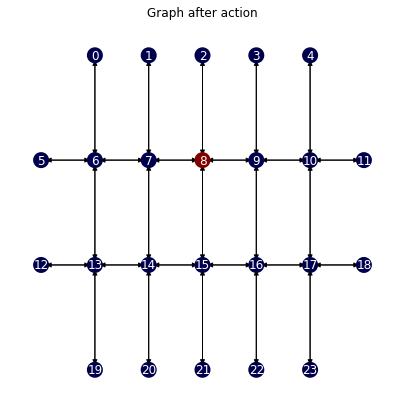

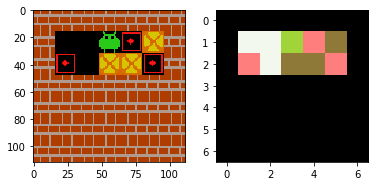

STEP 48


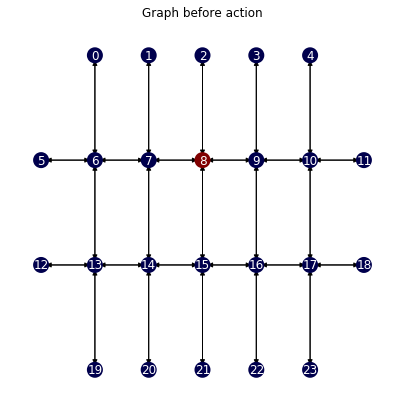

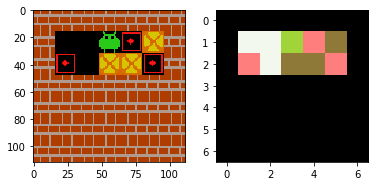

Node index: 15. Action: 2 (push down).


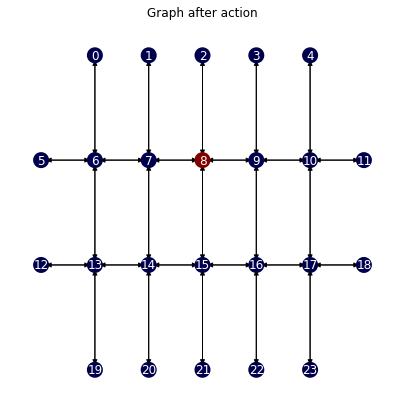

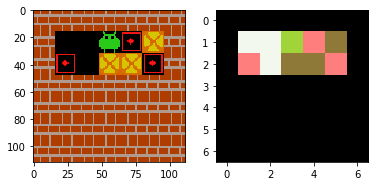

STEP 49


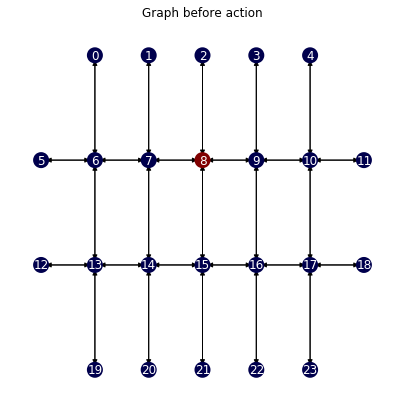

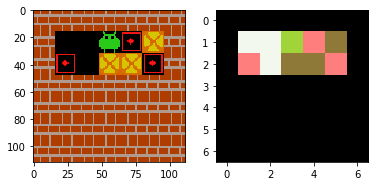

Node index: 9. Action: 8 (move right).


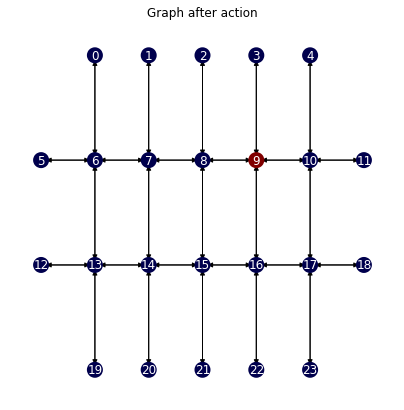

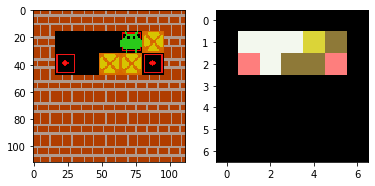

In [15]:
for i in range(50):
    print(f"STEP {i}")
    test_node_to_action()

## Node to action using net

In [40]:
from model.network import Net
from rl.explore import best_from_nodes

In [53]:
model = Net(emb.NUM_NODES_FEATURES)
model.load_state_dict(torch.load("test.pth"))                    
model.eval()

Net(
  (conv_i): GCNConv(
    (lin): Linear(in_features=4, out_features=64, bias=True)
  )
  (convs_h): Sequential(
    (0): GCNConv(
      (lin): Linear(in_features=64, out_features=64, bias=True)
    )
    (1): GCNConv(
      (lin): Linear(in_features=64, out_features=64, bias=True)
    )
    (2): GCNConv(
      (lin): Linear(in_features=64, out_features=64, bias=True)
    )
    (3): GCNConv(
      (lin): Linear(in_features=64, out_features=64, bias=True)
    )
    (4): GCNConv(
      (lin): Linear(in_features=64, out_features=64, bias=True)
    )
    (5): GCNConv(
      (lin): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (conv_o): GCNConv(
    (lin): Linear(in_features=64, out_features=1, bias=True)
  )
)

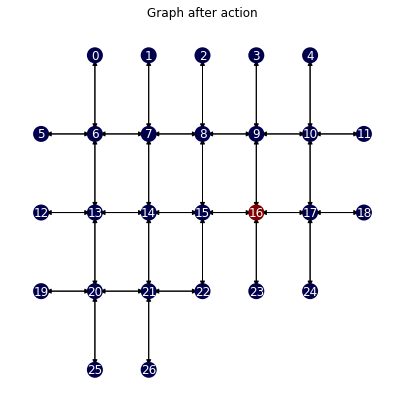

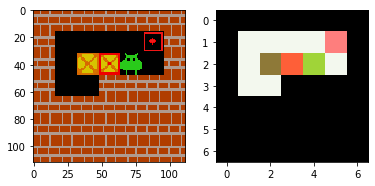

In [61]:
# _ = env.reset()
G, pos_map, labels = get_state(emb)
show_graph(to_networkx(G), pos_map, node_color=G.x[:, 1], node_text=labels, title="Graph after action")
show_grids()

In [62]:
Q = model(G.x, G.edge_index)

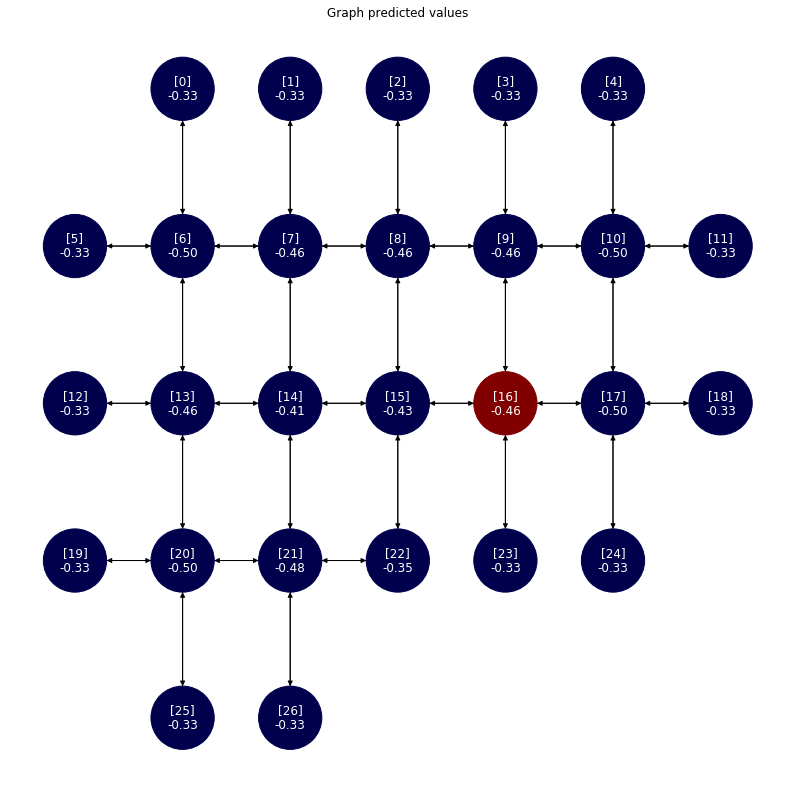

In [63]:
Q_values_text = {i: f"[{i}]\n{value.item():.2f}" for i, value in enumerate(Q)} 
plt.figure(1, figsize=(14, 14)) 
plt.title("Graph predicted values")
nx.draw(to_networkx(G), 
        cmap=plt.get_cmap('seismic'), 
        node_color=G.x[:, 1], 
        labels=Q_values_text, 
        node_size=4000, 
        linewidths=1, 
        font_color="w",
        pos=pos_map)
plt.show()

In [57]:
best_from_nodes(Q, G, False, False)

tensor(24)

In [58]:
best_from_nodes(Q, G)

tensor(16)

In [59]:
env.get_action_lookup()

{0: 'no operation',
 1: 'push up',
 2: 'push down',
 3: 'push left',
 4: 'push right',
 5: 'move up',
 6: 'move down',
 7: 'move left',
 8: 'move right'}

In [60]:
_ = env.step(3)